# BO Multiopt

This notebook evaluate the abilities of BayBE to perform a dual optimization. For this, default settings are being used alongside the Morgan fingerprint (radius = 2, bit length = 1024). The optimization tries to maximize the ee_R while keeping the undesired yield low.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import getMolFromSmile, SmilesToDescriptors
import seaborn as sns
from baybe.utils.random import set_random_seed

set_random_seed(11)

In [18]:
#load the dataset, if not available run process_database.py first

df = pd.read_csv('dataset.csv')
df.head(2)

,reactant_1,reactant_2,reactant_3,product_R,product_S,solvent,catalyst_1,catalyst_2,product_undesired_R,product_undesired_S,ee_R,ee_S,ee_undesired_R,ee_undesired_S,yield_undesired_R,yield_undesired_S,reaction,curated_catalyst_2
0,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,0.63,-0.63,0.0,0.0,0.095598,0.094402,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C1COCCN1.F[P](F)...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...
1,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,44.66,-44.66,0.0,0.0,0.412281,0.157719,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C[Si](C)(C)OC(c1...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...


#### Pareto plot

Define the optimal region to be, the parreto front, which minimizes the undesired product and maximizes the ee_R.

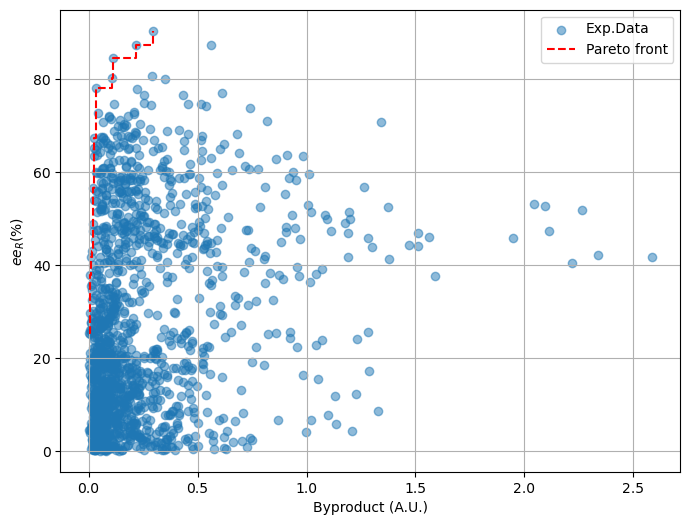

In [19]:
df['abs_ee_R'] = df['ee_R'].abs()
points = df[['abs_ee_R', 'yield_undesired_R']].values

def pareto_front_northwest(points):
    pareto = []
    for i, (x, y) in enumerate(points):
        dominated = False
        for j, (x2, y2) in enumerate(points):
            if i != j and x2 >= x and y2 <= y and (x2 > x or y2 < y):
                dominated = True
                break
        if not dominated:
            pareto.append((x, y))
    return np.array(pareto)

pareto_points = pareto_front_northwest(points)

# Sort pareto points by Byproduct (x-axis, pareto_points[:,1])
sorted_indices = np.argsort(pareto_points[:, 1])
pareto_points_sorted = pareto_points[sorted_indices]

plt.figure(figsize=(8, 6))
plt.scatter(points[:, 1], points[:, 0], alpha=0.5, label="Exp.Data")
plt.step(pareto_points_sorted[:, 1], pareto_points_sorted[:, 0], where='post', linestyle='--', color='red', label="Pareto front")
plt.xlabel("Byproduct (A.U.)")
plt.ylabel(r'$\mathit{ee}_{R}(\%)$')
plt.legend()
plt.grid(True)
plt.savefig("./figures/Pareto_Front_Sorted.png")
plt.show()


#### Pareto optimization

In [20]:
reactant_1_pool = df['reactant_1'].unique()
catalyst_1_pool = df['catalyst_1'].unique()
catalyst_2_pool = df['catalyst_2'].unique()

In [21]:
reactant_1_descriptors = SmilesToDescriptors(reactant_1_pool, method='Morgan')
catalyst_1_descriptors = SmilesToDescriptors(catalyst_1_pool, method='Morgan')
catalyst_2_descriptors = SmilesToDescriptors(catalyst_2_pool, method='Morgan', sanitize=False)

reactant_1_descriptors.head(3)

,33,46,64,90,114,125,133,136,145,175,216,235,236,289,317,322,383,385,386,389,393,429,512,548,561,578,607,625,641,646,659,673,695,698,699,718,736,745,754,781,799,809,816,831,841,896,904,909,940,961
c1ccc(C(=O)CBr)cc1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Cc1ccc(C(=O)CBr)cc1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
Oc1ccc(C(=O)CBr)cc1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [22]:
from baybe.targets import NumericalTarget
from baybe.objectives import ParetoObjective
from baybe.parameters import CustomDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace

reactant_1_param = CustomDiscreteParameter(
    name='reactant_1',
    data=reactant_1_descriptors,
    decorrelate=0.7,
)

catalyst_1_param = CustomDiscreteParameter(
    name='catalyst_1',
    data=catalyst_1_descriptors,
    decorrelate=0.7,
)

catalyst_2_param = CustomDiscreteParameter(
    name='catalyst_2',
    data=catalyst_2_descriptors,
    decorrelate=0.7,
)

parameters = [
    reactant_1_param,
    catalyst_1_param,
    catalyst_2_param,
]

searchspace = SearchSpace.from_product(parameters)


#define multiple targets for the Pareto optimization
target_1 = NumericalTarget(
    name="ee_R",
    mode="MAX",
)
target_2 = NumericalTarget(
    name="yield_undesired_R",
    mode="MIN",
)

objective = ParetoObjective(targets=[target_1, target_2])

#add the undesired yield to the lookup table
lookup = df[['reactant_1', 'catalyst_1', 'catalyst_2', 'ee_R', 'yield_undesired_R']]
lookup.head(2)

,reactant_1,catalyst_1,catalyst_2,ee_R,yield_undesired_R
0,c1ccc(C(=O)CBr)cc1,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,0.63,0.095598
1,c1ccc(C(=O)CBr)cc1,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,44.66,0.412281


In [23]:
#same setup as usual
#takes around 17 minutes on my laptop (11th Gen i7 @ 2.80 GHz, 16GB RAM)

from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.recommenders import (
    BotorchRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
    RandomRecommender,
    )

BATCH_SIZE = 1
N_DOE_ITERATIONS = 100
N_MC_ITERATIONS = 5

botorch_fps_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),   # farthest point sampling
    recommender=BotorchRecommender(),       # Bayesian optimization
    switch_after=10,                        # switch to Botorch after 10 iterations
    )


random_recommender = RandomRecommender()

botorch_fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_fps_recommender)

random_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=random_recommender)

scenarios = {"GP FPS-Multi": botorch_fps_campaign, "Random": random_campaign}

results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

100%|##########| 10/10 [16:02<00:00, 96.26s/it]


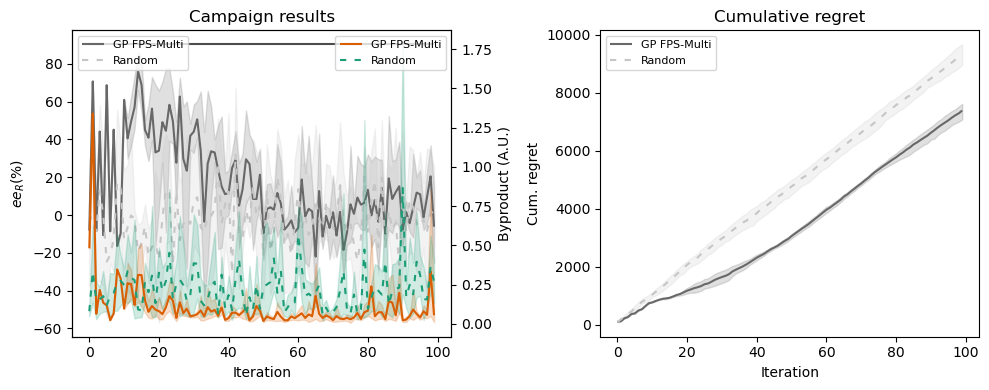

In [24]:
def plot_results_multi(results, lookup, figure_name, nbr_controls=1):
  """ 
  Function to plot the results of the multi-objective optimization.
  """
  
  if nbr_controls < 1:
    raise ValueError('You need at least one control campaign')

  dashes = [(1,0)]*(results['Scenario'].nunique()-nbr_controls+1) + [(3,4)]*(nbr_controls-1)

  colors = sns.color_palette('Set1', results['Scenario'].nunique()-nbr_controls)
  greys = sns.color_palette('Greys', nbr_controls)[::-1]
  palette = colors + greys
  
  colors_alt = sns.color_palette('Paired', results['Scenario'].nunique() - nbr_controls)
  greys_alt = sns.color_palette('Dark2', nbr_controls)[::-1]
  palette_alt = colors_alt + greys_alt

  optimum = lookup['ee_R'].max()
  #add columns
  results['ins_regret'] = optimum - results['ee_R_IterBest']
  results['sim_regret'] = optimum - results['ee_R_CumBest']
  results['cum_regret'] = results.groupby(['Scenario', 'Monte_Carlo_Run'], group_keys=False)['ins_regret'].cumsum()

  optimum = lookup['yield_undesired_R'].min()
  #add columns
  results['ins_regret_yield'] = optimum - results['yield_undesired_R_IterBest']
  results['sim_regret_yield'] = optimum - results['yield_undesired_R_CumBest']
  results['cum_regret_yield'] = results.groupby(['Scenario', 'Monte_Carlo_Run'], group_keys=False)['ins_regret_yield'].cumsum()

  #Campaigns results
  iterMax = results['Iteration'].max()

  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  ax=ax.flatten()
  ax[0].hlines(y=lookup['ee_R'].max(), color='black', alpha=0.7, xmin=0, xmax=iterMax)
  
  sns.lineplot(data=results, x='Iteration', y='ee_R_IterBest', hue='Scenario', style='Scenario', dashes=dashes, palette=palette, ax=ax[0])
  ax_2 = ax[0].twinx()
  sns.lineplot(data=results, x='Iteration', y='yield_undesired_R_IterBest', hue='Scenario', style='Scenario', dashes=dashes, palette=palette_alt, ax=ax_2)
  ax_2.set_ylabel("Byproduct (A.U.)")
  ax_2.legend(fontsize=8, loc='upper right')
  ax[0].set_ylabel(r'$\mathit{ee}_{R}(\%)$')
  ax[0].legend(fontsize=8, loc='upper left')
  ax[0].set_title('Campaign results')

  sns.lineplot(data=results, x='Iteration', y='cum_regret', hue='Scenario', style='Scenario', dashes=dashes, palette=palette, ax=ax[1])
  ax[1].set_title('Cumulative regret')
  ax[1].set_ylabel('Cum. regret')
  ax[1].legend(fontsize=8)
  plt.tight_layout()
  plt.savefig('./figures/'+figure_name, dpi=300)


plot_results_multi(results, lookup, figure_name= 'multibo.png', nbr_controls=2)


In [25]:
results

,Scenario,Monte_Carlo_Run,Iteration,Num_Experiments,ee_R_Measurements,yield_undesired_R_Measurements,ee_R_IterBest,ee_R_CumBest,yield_undesired_R_IterBest,yield_undesired_R_CumBest,ins_regret,sim_regret,cum_regret,ins_regret_yield,sim_regret_yield,cum_regret_yield
0,GP FPS-Multi,0,0,1,[-8.270000457763672],[0.4815824925899505],-8.270000,-8.270000,0.481582,0.481582,98.719997,98.719997,98.719997,-0.481582,-0.481582,-0.481582
1,GP FPS-Multi,0,1,2,[70.7699966430664],[1.3405444622039795],70.769997,70.769997,1.340544,0.481582,19.680000,19.680000,118.399998,-1.340544,-0.481582,-1.822127
2,GP FPS-Multi,0,2,3,[-8.460000038146973],[0.064078003168106],-8.460000,70.769997,0.064078,0.064078,98.909997,19.680000,217.309995,-0.064078,-0.064078,-1.886205
3,GP FPS-Multi,0,3,4,[44.22999954223633],[0.2163449972867965],44.230000,70.769997,0.216345,0.064078,46.219997,19.680000,263.529992,-0.216345,-0.064078,-2.102550
4,GP FPS-Multi,0,4,5,[-10.670000076293944],[0.1339949965476989],-10.670000,70.769997,0.133995,0.064078,101.119997,19.680000,364.649989,-0.133995,-0.064078,-2.236545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Random,4,95,96,[-25.40999984741211],[0.4475400149822235],-25.410000,84.510002,0.447540,0.009972,115.859997,5.939995,9193.439702,-0.447540,-0.009972,-21.180722
996,Random,4,96,97,[-25.13999938964844],[0.0074860001914203],-25.139999,84.510002,0.007486,0.007486,115.589996,5.939995,9309.029699,-0.007486,-0.007486,-21.188208
997,Random,4,97,98,[-66.47000122070312],[0.1592675000429153],-66.470001,84.510002,0.159268,0.007486,156.919998,5.939995,9465.949697,-0.159268,-0.007486,-21.347476
998,Random,4,98,99,[-5.050000190734863],[0.1804050058126449],-5.050000,84.510002,0.180405,0.007486,95.499997,5.939995,9561.449694,-0.180405,-0.007486,-21.527881
